In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

2024-12-19 10:28:47.670922: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 10:28:47.692743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 10:28:47.692758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 10:28:47.693397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 10:28:47.697053: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2024-12-19 10:28:50.215689: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-19 10:28:50.215908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-19 10:28:50.239559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Dataset

In [3]:
df = pd.read_pickle('aug_dataset_finegrained.pkl')
#df = pd.read_pickle('./text2ImgData_text_version.pkl')
#for test only.....
# Use slicing to get the first `nrows` rows
#nrows = 64
#df = df.iloc[:nrows]
#for test only

num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 58960 image in training data


In [4]:
df.head()

,Captions,ImagePath,labels
ID,,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./aug_dataset_finegrained/image_06734.jpg,1
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./aug_dataset_finegrained/image_06736.jpg,1
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./aug_dataset_finegrained/image_06737.jpg,1
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./aug_dataset_finegrained/image_06738.jpg,1
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./aug_dataset_finegrained/image_06739.jpg,1


In [5]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [6]:
#add CLS token
word2Id_dict['<CLS>']='5429'
id2word_dict['5429']='<CLS>'
#add EOS token
word2Id_dict['<EOS>']='5430'
id2word_dict['5430']='<EOS>'

In [7]:
print(len(word2Id_dict))
print(len(id2word_dict))

5430
5431


In [8]:
id2word_dict['0']

'<PAD>'

[['9', '1', '5', '11', '2', '7', '42', '60', '3', '21', '86', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '241', '521', '1', '5', '77', '283', '22', '141', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['8', '1', '7', '22', '2', '3', '111', '70', '74', '13', '879', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '90', '11', '2', '7', '503', '42', '60', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '3', '71', '13', '18', '7', '2', '10', '6', '42', '27', '9', '174', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '44', '3', '21', '13', '18', '3', '5', '2', '10', '6', '42', '27', '9', '60', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '7', '141', '60', '3', '8', '25', '21', '3', '22', '86', '5427', '5427', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '10', '626', '89', '8', '21', '101', '7', '3220', 

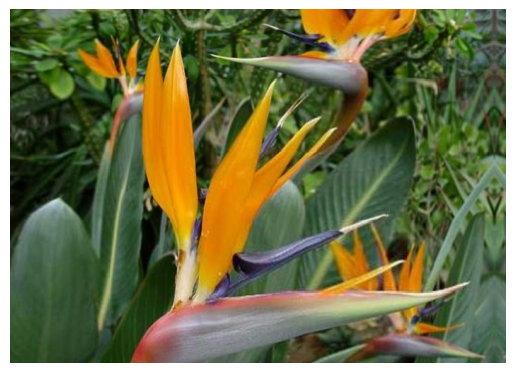

[['9', '1', '5', '11', '2', '7', '42', '60', '3', '21', '86', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '241', '521', '1', '5', '77', '283', '22', '141', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['8', '1', '7', '22', '2', '3', '111', '70', '74', '13', '879', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '90', '11', '2', '7', '503', '42', '60', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '3', '71', '13', '18', '7', '2', '10', '6', '42', '27', '9', '174', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '44', '3', '21', '13', '18', '3', '5', '2', '10', '6', '42', '27', '9', '60', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '7', '141', '60', '3', '8', '25', '21', '3', '22', '86', '5427', '5427', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '10', '626', '89', '8', '21', '101', '7', '3220', 

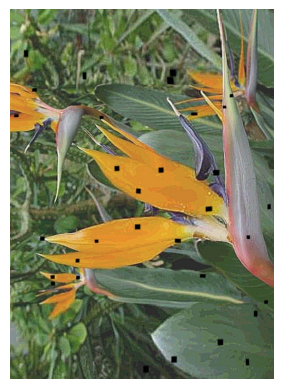

[['9', '1', '5', '11', '2', '7', '42', '60', '3', '21', '86', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '241', '521', '1', '5', '77', '283', '22', '141', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['8', '1', '7', '22', '2', '3', '111', '70', '74', '13', '879', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '90', '11', '2', '7', '503', '42', '60', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '3', '71', '13', '18', '7', '2', '10', '6', '42', '27', '9', '174', '5427', '5427', '5427', '5427'], ['4', '1', '15', '22', '44', '3', '21', '13', '18', '3', '5', '2', '10', '6', '42', '27', '9', '60', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '7', '141', '60', '3', '8', '25', '21', '3', '22', '86', '5427', '5427', '5427', '5427'], ['4', '1', '5', '25', '22', '2', '10', '626', '89', '8', '21', '101', '7', '3220', 

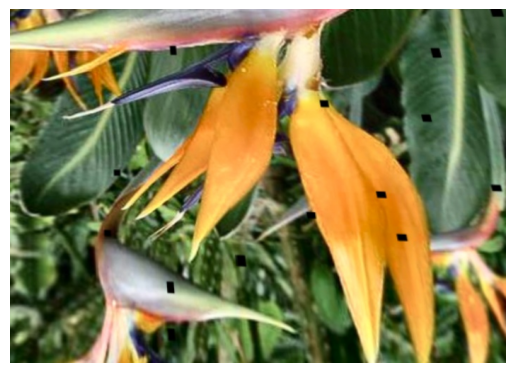

In [9]:
import cv2
for i in range(10006,10009):
  idx = df.index[i]
  captions = df['Captions'][idx]
  image_path = df['ImagePath'][idx]
  image_path = image_path

  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  print(captions)

  # Step 3: Display the image using Matplotlib
  plt.imshow(image)
  plt.axis("off")  # Hide the axes for better visualization
  plt.show()

# Create Dataset by Dataset API

In [9]:
MAX_SEQ_LENGTH=25

In [10]:
REPEAT_TIME=1

In [11]:
import random
import copy
from tensorflow.keras.preprocessing.sequence import pad_sequences
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

In [13]:
def generate_image(image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - 0.5) * 2 #[-1,1]
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return img

def training_data_generator(caption, wrong_caption, image_path, wrong_image_path):
    img = generate_image(image_path)
    img_w = generate_image(wrong_image_path)

    caption = tf.cast(caption, tf.int32)
    caption_w = tf.cast(wrong_caption, tf.int32)

    return img, img_w, caption, caption_w

def dataset_generator(df, batch_size, data_generator):
    # load the training data into two NumPy arrays
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        sampled_caption = copy.deepcopy(random.choice(captions[i]))
        # Insert '5429' at the beginning<CLS>
        sampled_caption.insert(0, '5429')
        # If '5427' exists, find its index and insert '5430' before it
        if '5427' in sampled_caption:
            index_5427 = sampled_caption.index('5427')
            sampled_caption.insert(index_5427, '5430')
        # If '5427' does not exist, insert '5430' at the end
        else:
            sampled_caption.append('5430')

        # Replace '5427' with '0' for padding
        sampled_caption = ['0' if token == '5427' else token for token in sampled_caption]
        
        caption.append(sampled_caption)
    
    # Pad captions to a uniform length
    caption = pad_sequences(caption, padding='post', value=0, dtype='int32', maxlen=MAX_SEQ_LENGTH)
    
    image_path = df['ImagePath'].values

    wrong_caption = copy.deepcopy(caption)
    random.shuffle(wrong_caption)

    wrong_image_path = copy.deepcopy(image_path)
    random.shuffle(wrong_image_path)

    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]

    dataset = tf.data.Dataset.from_tensor_slices((caption, wrong_caption, image_path, wrong_image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption))
    dataset = dataset.repeat(REPEAT_TIME)  # Repeat here
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [12]:
BATCH_SIZE = 64

In [13]:
dataset = dataset_generator(df, BATCH_SIZE, training_data_generator)

NameError: name 'dataset_generator' is not defined

In [16]:
for img, img_w, caption, caption_w in dataset.take(1):
  print(caption.numpy()[:10])
  
  print(caption_w.numpy()[:10])
  

2024-12-13 05:37:51.672672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 7260 of 58960
2024-12-13 05:38:01.673141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 15945 of 58960
2024-12-13 05:38:21.672627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 31871 of 58960
2024-12-13 05:38:41.675944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 48969 of 58960
2024-12-13 05:38:52.992920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


[[5429    4    1   15   11    3   16   13   18    3    5    2   10    6
   100 5430    0    0    0    0    0    0    0    0    0]
 [5429    9    2   27    4    1    6   14    3  289  711  341    3    9
    33   15   21 5430    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   14    3    5   11   19 5430    0
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5   25   12    2    3    8  164   17   11   56   13
     9   76 5430    0    0    0    0    0    0    0    0]
 [5429    4  131    1    5    2   10    6   75    3   37    7   11 5430
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   16    7   12   19 5430    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   14    3   12    7   11   19 5430
     0    0    0    0    0    0    0    0    0    0    0]
 [5429    4    1    5    2   10    6   12    3    5   11   88 5430    0
     0    0    0  

# textencoder

In [13]:
# Define positional encoding function
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)

    angle_rates = 1 / (10000 ** depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # Scale the embeddings by the square root of the model depth
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Add positional encoding to the embeddings
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Save the parameters needed to recreate the layer
        return {
            "vocab_size": self.vocab_size,
            "d_model": self.d_model
        }

    @classmethod
    def from_config(cls, config):
        # Create a new instance from the saved configuration
        return cls(**config)

In [15]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        self.mha_config = kwargs  # Store the MHA configuration for serialization

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=mask,
            training=training  # Pass training to MHA if applicable
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x, training=training)  # Pass training to LayerNormalization if applicable
        return x

    def get_config(self):
        config = super().get_config()  # Base layer configuration
        config.update(self.mha_config)  # Add MultiHeadAttention configuration
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [16]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x, mask=None, training=False):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=mask,
            training=training  # Pass training to MHA
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x, training=training)  # Pass training to LayerNormalization if applicable
        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Retrieve the base configuration from BaseAttention
        base_config = super().get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        # Recreate GlobalSelfAttention using BaseAttention's logic
        return cls(**config)

In [17]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.dense_1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x, training=False):
        # Process through the feed-forward network
        seq_output = self.dense_1(x)  # First dense layer
        seq_output = self.dense_2(seq_output)  # Second dense layer
        seq_output = self.dropout(seq_output, training=training)  # Apply dropout based on training

        # Add residual connection and apply normalization
        x = self.add([x, seq_output])
        x = self.layer_norm(x)
        return x

    def get_config(self):
        # Save the class configuration
        config = super().get_config()  # Base configuration
        config.update({
            "d_model": self.d_model,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create an instance from the saved configuration
        return cls(**config)

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.ffn = FeedForward(d_model, dff, dropout_rate)

    def call(self, x, mask, training=False):
        # Apply self-attention with the training flag
        x = self.self_attention(x, mask=mask, training=training)
        
        # Apply the feed-forward network with the training flag
        x = self.ffn(x, training=training)
        
        return x  # (batch_size, seq_length, d_model)

    def get_config(self):
        # Save the class configuration
        config = super().get_config()  # Base configuration
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate the layer from its configuration
        return cls(**config)

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate

        # Positional Embedding layer
        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        # Stack of Encoder layers
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]

        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, seq_length, training=False):
        # Token embeddings with positional encoding
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`

        # Generate the attention mask
        mask = x._keras_mask  # Shape `(batch_size, seq_length)`
        reshaped_mask = tf.reshape(mask, (-1, seq_length, 1))  # `(batch_size, seq_length, 1)`
        reshaped_mask = tf.cast(reshaped_mask, tf.int32)
        result_mask = tf.matmul(reshaped_mask, tf.transpose(reshaped_mask, perm=[0, 2, 1]))
        result_mask = tf.cast(result_mask, tf.bool)

        # Apply dropout (respect the `training` flag)
        x = self.dropout(x, training=training)

        # Pass through the stack of Encoder layers
        for enc_layer in self.enc_layers:
            x = enc_layer(x, result_mask, training=training)

        # Extract the CLS token representation (first token)
        cls_token_output = x[:, 0, :]  # Shape `(batch_size, d_model)`

        return cls_token_output

    def get_config(self):
        # Save configuration for serialization
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "vocab_size": self.vocab_size,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate the Encoder from its config
        return cls(**config)

# Generator

In [20]:
class DecayingGaussianNoise(tf.keras.layers.Layer):
    """
    Custom Gaussian noise layer with decaying stddev.
    """
    def __init__(self, initial_stddev=0.1, decay_rate=0.55, **kwargs):
        super(DecayingGaussianNoise, self).__init__(**kwargs)
        self.initial_stddev = initial_stddev
        self.decay_rate = decay_rate
        self.current_stddev = initial_stddev  # Initialize the current stddev

    def call(self, inputs, training=False, epoch=0):
        if training:
            # Decay the stddev based on the current epoch
            self.current_stddev = self.initial_stddev / ((300 + epoch) ** self.decay_rate)
            noise = tf.random.normal(shape=tf.shape(inputs), stddev=self.current_stddev)
            return inputs + noise
        return inputs


class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z.
    Input: text and noise
    Output: fake image with size 64*64*3
    """
    def __init__(self, hparas, output_shape=(64, 64, 3)):
        super(Generator, self).__init__()

        self.hparas = hparas
        self.flatten = tf.keras.layers.Flatten()

        # Decaying Gaussian noise layer
        self.decaying_noise = DecayingGaussianNoise(initial_stddev=0.1, decay_rate=0.55)

        self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.batch_norm_text = tf.keras.layers.BatchNormalization()

        # Calculate the base spatial size (8x8 for 64x64 output)
        self.base_size = (8, 8)
        self.output_channels = output_shape[-1]

        # Dense layer to project latent space to base resolution
        self.dense = tf.keras.layers.Dense(
            units=self.base_size[0] * self.base_size[1] * 256,
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()

        # Reshape to base spatial resolution
        self.reshape = tf.keras.layers.Reshape((self.base_size[0], self.base_size[1], 256))

        # Upsampling layers
        self.conv2d_t1 = tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()

        self.conv2d_t2 = tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.leaky_relu3 = tf.keras.layers.LeakyReLU()

        self.conv2d_t3 = tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.leaky_relu4 = tf.keras.layers.LeakyReLU()

        # Final output layer
        self.output_layer = tf.keras.layers.Conv2DTranspose(
            filters=self.output_channels,
            kernel_size=(5, 5),
            strides=(1, 1),
            padding='same',
            activation='tanh',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )

    def call(self, text, noise_z, epoch=0, training=True):
        """
        Forward pass for the generator.
        """
        # Pass through the text encoder
        text = self.flatten(text)
        text = self.decaying_noise(text, training=training, epoch=epoch)  # Add decaying Gaussian noise
        text = self.d1(text)
        text = self.batch_norm_text(text, training=training)
        text = tf.nn.leaky_relu(text)

        x = tf.concat([noise_z, text], axis=1)

        # Pass through the dense and reshape layers
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.dense(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm1(x, training=training)
        x = self.leaky_relu1(x)
        x = self.reshape(x)

        # Pass through upsampling layers
        x = self.conv2d_t1(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm2(x, training=training)
        x = self.leaky_relu2(x)

        x = self.conv2d_t2(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm3(x, training=training)
        x = self.leaky_relu3(x)

        x = self.conv2d_t3(x)
        x = self.decaying_noise(x, training=training, epoch=epoch)  # Add decaying Gaussian noise
        x = self.batch_norm4(x, training=training)
        x = self.leaky_relu4(x)

        # Final output layer
        x = self.output_layer(x)

        return x


In [23]:
#noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
#text_encoder = TextEncoder(hparas)
#hidden = text_encoder.initialize_hidden_state()
#generator = Generator(hparas)
#for image, caption in dataset.take(1):
#  text_embed, hidden = text_encoder(caption, hidden)
#  output = generator(text_embed, noise)
#  print(output.shape)

# Discriminator

In [21]:
class Discriminator(tf.keras.Model):
    """
    Discriminator model to distinguish real images from fake ones.
    Input: Image of shape (64, 64, 3)
    Output: Probability (scalar) indicating whether the image is real or fake.
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()

        self.hparas = hparas
        self.flatten_text = tf.keras.layers.Flatten()
        self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])

        # First Conv2D layer
        self.conv1 = layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm1 = layers.BatchNormalization()
        self.leaky_relu1 = layers.LeakyReLU(alpha=0.2)
        self.dropout1 = layers.Dropout(0.3)

        # Second Conv2D layer
        self.conv2 = layers.Conv2D(
            128, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU(alpha=0.2)
        self.dropout2 = layers.Dropout(0.3)

        # Third Conv2D layer
        self.conv3 = layers.Conv2D(
            256, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU(alpha=0.2)
        self.dropout3 = layers.Dropout(0.3)

        # Fourth Conv2D layer
        self.conv4 = layers.Conv2D(
            512, (5, 5), strides=(2, 2), padding='same',
            kernel_initializer=tf.random_normal_initializer(mean=0., stddev=0.02)
        )
        self.batch_norm4 = layers.BatchNormalization()
        self.leaky_relu4 = layers.LeakyReLU(alpha=0.2)
        self.dropout4 = layers.Dropout(0.3)

        self.conv5 = layers.Conv2D(
            filters = 64*8, kernel_size = 1, strides = 1, padding = "same",
            kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 0.02))
        self.batch_norm5 = layers.BatchNormalization()
        self.leaky_relu5 = layers.LeakyReLU(alpha=0.2)

        # Flatten and output layer
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    def call(self, img, text, training=True):
        """
        Forward pass through the discriminator model.
        Args:
            img: Input tensor (image batch).
            text: Text feature tensor.
            training: Boolean, specifies if the model is being trained or evaluated (for BatchNormalization).
        Returns:
            logits: Raw logits.
            output: Sigmoid-activated probability (scalar between 0 and 1).
        """
        # Process the text feature
        text = self.flatten_text(text)
        text = self.d_text(text)
        text = tf.nn.leaky_relu(text)

        # Process the image feature
        img = self.conv1(img)
        img = self.batch_norm1(img, training=training)
        img = self.leaky_relu1(img)
        img = self.dropout1(img, training=training)

        img = self.conv2(img)
        img = self.batch_norm2(img, training=training)
        img = self.leaky_relu2(img)
        img = self.dropout2(img, training=training)

        img = self.conv3(img)
        img = self.batch_norm3(img, training=training)
        img = self.leaky_relu3(img)
        img = self.dropout3(img, training=training)

        img = self.conv4(img)
        img = self.batch_norm4(img, training=training)
        img = self.leaky_relu4(img)
        img = self.dropout4(img, training=training)

        text = tf.reshape(text, [text.shape[0], 1, 1, text.shape[1]])#text shape(batch, embed)
        text = tf.tile(text, [1, img.shape[1], img.shape[2], 1])

        # Concatenate image and text features
        x = tf.concat([text, img], axis=-1)

        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = self.leaky_relu5(x)

        x = self.flatten(x)

        logits = self.dense(x)
        output = tf.nn.sigmoid(logits)

        return logits, output

In [ ]:
#discriminator = Discriminator(hparas)
#for image, caption in dataset.take(1):
#  text_embed, hidden = text_encoder(caption, hidden)
#  logits, output = discriminator(image, text_embed)
#  print(output)

In [22]:
EMBEDDING_DIM=512
NUM_HEADS=2
NUM_LAYERS=2
VOCAB_SIZE=len(id2word_dict)
DFF = 2048

In [23]:
text_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=EMBEDDING_DIM,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

In [24]:
# Initialize the model by calling it with dummy input
dummy_input = tf.random.uniform((1, MAX_SEQ_LENGTH), maxval=VOCAB_SIZE, dtype=tf.int32)  # Batch size of 1, sequence length of 10
seq_length = tf.shape(dummy_input)[1]  # Infer sequence length from dummy input
_ = text_encoder(dummy_input, seq_length=MAX_SEQ_LENGTH, training=False)  # Call the model to initialize weights

# Load the saved weights
text_encoder.load_weights('encoder_weights.h5')

print("Weights successfully loaded!")

2024-12-19 10:29:16.233794: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Weights successfully loaded!


2024-12-19 10:29:16.491577: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


In [25]:
hparas = {
    'MAX_SEQ_LENGTH': MAX_SEQ_LENGTH,                     # maximum sequence length
    'EMBED_DIM': EMBEDDING_DIM,                         # word embedding dimension
    'VOCAB_SIZE': len(id2word_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': EMBEDDING_DIM,                   # number of RNN neurons
    'Z_DIM': 1024,                             # random noise z dimension
    'DENSE_DIM': EMBEDDING_DIM,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 800,                            # number of epoch for demo
    'N_SAMPLE': num_training_sample*REPEAT_TIME,          # size of training data(repeat 10 times)
    'CHECKPOINTS_DIR': './checkpoints/demo2',  # checkpoint path
    'SAMPLE_DIR': 'samples/demo2',
    'PRINT_FREQ': 40                           # printing frequency of loss
}

In [26]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

# Loss Function and Optimization

In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(real_logits, fake_logits, real_logits_cw, real_logits_iw):
    # output value of real image should be 1
    #label smoothing here
    real_loss = cross_entropy(tf.random.uniform(real_logits.shape, minval=0.9, maxval=1), real_logits)
    # output value of fake image should be 0
    #label smoothing here
    fake_loss = cross_entropy(tf.random.uniform(fake_logits.shape, minval=0, maxval=0.1), fake_logits)

    real_cw_loss = cross_entropy(tf.random.uniform(real_logits_cw.shape, minval=0, maxval=0.1), real_logits_cw)

    real_iw_loss = cross_entropy(tf.random.uniform(real_logits_iw.shape, minval=0, maxval=0.1), real_logits_iw)

    total_loss = real_loss + 0.5* (fake_loss + real_cw_loss + real_iw_loss)
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

In [30]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
@tf.function
def train_step(img, img_w, caption, caption_w, epoch):
    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Encode the text using the myencoder
        text_embed = text_encoder(caption, seq_length=MAX_SEQ_LENGTH, training=False)

        text_embed_w = text_encoder(caption_w, seq_length=MAX_SEQ_LENGTH, training=False)

        fake_image = generator(text=text_embed, noise_z=noise, epoch=epoch)

        real_logits, real_output = discriminator(img, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)

        #img with caption_w
        real_logits_cw, real_output_cw = discriminator(img, text_embed_w)
        #img_w with caption
        real_logits_iw, real_output_iw = discriminator(img_w, text_embed)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, real_logits_cw, real_logits_iw)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))

    return g_loss, d_loss

In [32]:
@tf.function
def test_step(caption, noise):
    # Encode the text using the myencoder model
    text_embed = text_encoder(caption, seq_length=MAX_SEQ_LENGTH, training=False)
    
    fake_image = generator(text_embed, noise, training=False)
    return fake_image

# Visualiztion

In [33]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [34]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int32)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [35]:
def sent2IdList(line):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0

    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]

    # Insert '5429' at the beginning<CLS>
    tokens.insert(0, '<CLS>')
    #insert <EOS>
    tokens.append('<EOS>')
    
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l

    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]
    # Replace '5427' with '0' for padding
    line = ['0' if token == '5427' else token for token in line]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [38]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

In [39]:
for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
    if i<20:
        print(sample_sentence[i])
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5430', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['5429', '9', '1', '82', '5

# Training

In [36]:
if not os.path.exists(hparas['SAMPLE_DIR']):
    os.makedirs(hparas['SAMPLE_DIR'])

In [37]:
def train(dataset, epochs):

    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])

    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()

        for img, img_w, caption, caption_w in dataset:
            g_loss, d_loss = train_step(img, img_w, caption, caption_w, epoch)
            g_total_loss += g_loss
            d_total_loss += d_loss

        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)

        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))

        # save the model
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed)
            save_images(fake_image, [ni, ni], hparas['SAMPLE_DIR']+'/train_{:02d}.jpg'.format(epoch))

        # Clear session to release memory and reset the computational graph
        tf.keras.backend.clear_session()

In [44]:
checkpoint.restore(checkpoint_dir + '/ckpt-6').expect_partial()

In [ ]:
train(dataset, hparas['N_EPOCH'])

2024-12-17 09:55:12.486300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 12232 of 58960
2024-12-17 09:55:32.479634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 40248 of 58960
2024-12-17 09:55:42.486976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 54368 of 58960
2024-12-17 09:55:45.746165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-17 09:55:48.809894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-17 09:55:49.172077: I exter

Epoch 1, gen_loss: 2.6517, disc_loss: 0.5683
Time for epoch 1 is 157.8272 sec


2024-12-17 09:57:50.325996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 12333 of 58960
2024-12-17 09:58:10.324508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 40515 of 58960
2024-12-17 09:58:20.326232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 54788 of 58960
2024-12-17 09:58:23.218320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-12-17 09:58:24.268497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


# Evaluation

In [93]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.int32)
    return caption, index

def testing_dataset_generator(data, batch_size, data_generator):
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        sampled_caption = copy.deepcopy(captions[i])

        # Insert '5429' at the beginning<CLS>
        sampled_caption.insert(0, '5429')
        # If '5427' exists, find its index and insert '5430' before it
        if '5427' in sampled_caption:
            index_5427 = sampled_caption.index('5427')
            sampled_caption.insert(index_5427, '5430')
        # If '5427' does not exist, insert '5430' at the end
        else:
            sampled_caption.append('5430')

        # Replace '5427' with '0' for padding
        sampled_caption = ['0' if token == '5427' else token for token in sampled_caption]
        
        caption.append(sampled_caption)

    
    # Pad captions to a uniform length
    caption = pad_sequences(caption, padding='post', value=0, dtype='int32', maxlen=MAX_SEQ_LENGTH)
    
    index = data['ID'].values
    index = np.asarray(index)

    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)

    return dataset

In [94]:
data = pd.read_pickle('./dataset/testData.pkl')

In [95]:
data.head()

,ID,Captions
0,6735,"[4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ..."
1,6740,"[4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, 6..."
2,6746,"[8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, 5..."
3,6759,"[91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 56..."
4,6762,"[53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 5427..."


In [96]:
# Values you want to keep
keep_values = [6735, 4162, 786, 2992, 2951]

# Filter the DataFrame
filtered_data = data[data['ID'].isin(keep_values)]

print(filtered_data)

       ID                                           Captions
0    6735  [4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ...
345  4162  [4, 1, 15, 12, 16, 3, 11, 13, 18, 7, 2, 10, 6,...
404  2951  [9, 2, 17, 9, 1, 6, 13, 140, 55, 3, 6, 14, 13,...
409  2992  [1, 5, 45, 43, 24, 2, 7, 11, 14, 18, 3, 35, 19...
608   786  [4, 1, 5, 66, 64, 54, 12, 2, 7, 108, 42, 36, 3...


In [97]:
GENERATING_BATCHSIZE = 1

In [98]:
testing_dataset = testing_dataset_generator(filtered_data, GENERATING_BATCHSIZE, testing_data_generator)

In [99]:
for caption, idx in testing_dataset.take(1):
    print(caption)
    print(idx)

tf.Tensor(
[[5429    4   12    3   16    1    5  791    2    3   78   59 5430    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 25), dtype=int32)
tf.Tensor([6735], shape=(1,), dtype=int64)


In [100]:
captions = filtered_data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / GENERATING_BATCHSIZE)
print(EPOCH_TEST)

5


# Inferece

In [101]:
INFERENCE_PATH = './inference/demo5'

In [102]:
if not os.path.exists(INFERENCE_PATH):
    os.makedirs(INFERENCE_PATH)

In [103]:
def inference(dataset):

    sample_size = GENERATING_BATCHSIZE
    

    step = 0
    start = time.time()
    for captions, idx in dataset:

        if step > EPOCH_TEST:
            break
        random_scale = np.random.uniform(0, 1)  # Generate a random number between 0 and 1 for the scale
        sample_seed = np.random.normal(loc=0.0, scale=random_scale, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)

        fake_image = test_step(captions, sample_seed)
        step += 1
        for i in range(GENERATING_BATCHSIZE):

            plt.imsave(INFERENCE_PATH+'/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)

    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [104]:
checkpoint.restore(checkpoint_dir + '/ckpt-13').expect_partial()

In [ ]:
inference(testing_dataset)